Downloading: 100%|██████████| 68.7M/68.7M [01:25<00:00, 799kB/s] 


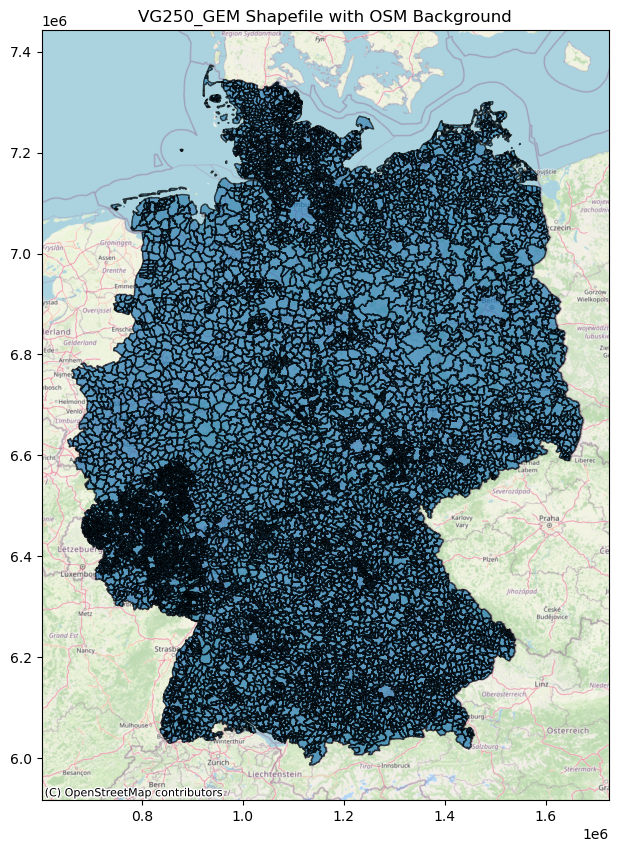

Saved Geopackage: /home/aleksandra/Downloads/data/gemeinde_raw.gpkg


In [17]:
import os
import requests
import zipfile
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import contextily as ctx  

# Extract municipality boundaries  from https://gdz.bkg.bund.de/index.php/default/digitale-geodaten/verwaltungsgebiete/verwaltungsgebiete-1-250-000-stand-01-01-vg250-01-01.html
HOME_DIR = os.path.expanduser("~")  
DOWNLOAD_DIR = os.path.join(HOME_DIR, "Downloads", "data")
os.makedirs(DOWNLOAD_DIR, exist_ok=True)
ZIP_PATH, EXTRACT_DIR = os.path.join(DOWNLOAD_DIR, "data.zip"), os.path.join(DOWNLOAD_DIR, "extracted")
OUTPUT_GPKG, TARGET_SHP = os.path.join(DOWNLOAD_DIR, "gemeinde_raw.gpkg"), "VG250_GEM.shp"

URL = "https://daten.gdz.bkg.bund.de/produkte/vg/vg250_ebenen_0101/aktuell/vg250_01-01.tm32.shape.ebenen.zip"

def download(url, path):
    if os.path.exists(path): os.remove(path)
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, stream=True)
    r.raise_for_status()
    
    with open(path, "wb") as f, tqdm(total=int(r.headers.get("content-length", 0)), unit="B", unit_scale=True, desc="Downloading") as pbar:
        for chunk in r.iter_content(8192):
            f.write(chunk)
            pbar.update(len(chunk))
    
    if not zipfile.is_zipfile(path):
        os.remove(path)
        raise ValueError("Invalid ZIP file.")

def extract(zip_path, folder, target_shp):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(folder)
    for root, _, files in os.walk(folder):
        if target_shp in files:
            return os.path.join(root, target_shp)
    raise FileNotFoundError(f"{target_shp} not found.")

def process_shapefile(path, output_gpkg):
    gdf = gpd.read_file(path).to_crs(epsg=3857)
    gdf.plot(figsize=(10, 10), edgecolor="black", alpha=0.7)
    ctx.add_basemap(plt.gca(), source=ctx.providers.OpenStreetMap.Mapnik)
    plt.title("VG250_GEM Shapefile with OSM Background")
    plt.show()
    gdf.to_file(output_gpkg, driver="GPKG")
    print(f"Saved Geopackage: {output_gpkg}")

if __name__ == "__main__":
    try:
        download(URL, ZIP_PATH)
        shp_path = extract(ZIP_PATH, EXTRACT_DIR, TARGET_SHP)
        process_shapefile(shp_path, OUTPUT_GPKG)
    except Exception as e:
        print(f"Error: {e}")

In [15]:
# Transform excel file with electrion results 

FILE_PATH = "/home/aleksandra/Downloads/DL_BB_GVW2024.xlsx"

def process_election_data(file_path):
    """Process election data from an Excel file and return a cleaned DataFrame."""
    
    df = pd.read_excel(file_path, sheet_name="BB_GVW2024")
    
    valid_types = ["P", "PV", "WG", "LV", "EB"]
    valid_names = ["Wähler", "Ungültig"]
    
    df = df.loc[df['Art des Wahl-vorschlags'].isin(valid_types) | 
                df['Merkmal\n\nKurzname'].isin(valid_names)]
    
    df['in Prozent¹'] = pd.to_numeric(df['in Prozent¹'], errors='coerce')
    
    #df['Art des Wahl-vorschlags'].fillna("Election Data", inplace=True)
    
    df = df.pivot_table(index='ARS', columns='Merkmal\n\nKurzname', values='in Prozent¹', aggfunc='first')
    
    df = df.replace("x", 0).apply(pd.to_numeric, errors='coerce').reset_index()
    
    keep_cols = [
        "ARS", "Wähler", "Ungültig",
        "AfD", "BVB / FREIE WÄHLER", "CDU", "DIE LINKE", "Die PARTEI", "FDP",
        "GRÜNE/B 90", "HEIMAT", "III. WEG", "PIRATEN", "SPD",
        "Tierschutzpartei", "Volt", "dieBasis", "ÖDP"
    ]
    
    df = df[[col for col in keep_cols if col in df.columns]]
    
    return df

df_cleaned = process_election_data(FILE_PATH)
df_cleaned

Merkmal Kurzname,ARS,Wähler,Ungültig,AfD,BVB / FREIE WÄHLER,CDU,DIE LINKE,Die PARTEI,FDP,GRÜNE/B 90,HEIMAT,III. WEG,PIRATEN,SPD,Tierschutzpartei,Volt,dieBasis,ÖDP
0,120510000000,58.0,2.0,23.8,9.5,23.6,7.2,NaN,2.8,8.9,NaN,NaN,NaN,18.7,NaN,NaN,NaN,NaN
1,120520000000,62.6,1.5,29.3,NaN,16.0,7.1,NaN,2.0,4.9,NaN,NaN,NaN,19.6,NaN,NaN,NaN,NaN
2,120530000000,58.2,2.0,28.7,NaN,22.9,15.8,4.9,3.8,NaN,NaN,NaN,NaN,12.7,NaN,NaN,NaN,NaN
3,120540000000,70.4,1.7,13.7,2.9,14.7,8.7,2.7,4.5,14.5,NaN,NaN,NaN,19.4,NaN,1.9,NaN,NaN
4,120600005005,74.2,1.5,23.0,NaN,15.5,4.8,NaN,NaN,4.2,NaN,NaN,NaN,10.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,120735306261,77.8,1.6,18.0,NaN,NaN,4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
409,120735306430,77.8,2.9,19.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410,120735306458,78.3,1.4,22.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,120735306578,74.1,2.6,15.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Merge municipalities GPKG with election results

INPUT_GPKG = os.path.join(DOWNLOAD_DIR, "gemeinde_raw.gpkg")
OUTPUT_ELECTION_GPKG = os.path.join(HOME_DIR, "Code/dvlp/bb_election_results.gpkg")

gdf = gpd.read_file(INPUT_GPKG)

gdf = gdf[gdf['SN_L'] == '12']
gdf.rename(columns={"GEN": "Gemeindename"}, inplace=True)
gdf = gdf[["Gemeindename", "ARS", "geometry"]]
gdf["ARS"] = gdf["ARS"].astype(float)

gdf_merged = gdf.merge(df_cleaned, on="ARS", how="left")

if not isinstance(gdf_merged, gpd.GeoDataFrame):
    gdf_merged = gpd.GeoDataFrame(gdf_merged, geometry="geometry")

gdf_merged = gdf_merged.rename(columns={
    "Wähler": "Wahlbeteiligung", 
    "GRÜNE/B 90": "GRÜNE", 
    "Ungültig": "Ungueltige Stimmabgabe"
})

gdf_merged = gdf_merged[['Gemeindename', 'geometry', 'Ungueltige Stimmabgabe', 
                          'AfD', 'CDU', 'SPD', 'DIE LINKE', 'GRÜNE', "Wahlbeteiligung"]]

gdf_merged.to_file(OUTPUT_ELECTION_GPKG)

print(f"File saved at: {OUTPUT_ELECTION_GPKG}")

File saved at: /home/aleksandra/Code/dvlp/bb_election_results.gpkg
